In [3]:
import os
import pandas as pd
os.chdir('C:/Users/doudi/Downloads/')
path = 'Reader_Emotion_Seg_no_stopword.csv'
f = pd.read_csv(path)

f.head()

f['concate'] = f['title_seg_no_stw']+f['content_seg_no_stw']

In [4]:
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras import optimizers
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers import Dense, Embedding
from keras.layers import Convolution1D, Flatten, Dropout, MaxPool1D, GlobalAveragePooling1D
from keras import initializers

Using TensorFlow backend.
C:\Users\doudi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\doudi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\doudi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\doudi\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [5]:
def textCNN(texts, labels):
    training_text, test_text, training_label, test_label = train_test_split(texts, labels, test_size=0.1)

    token = Tokenizer(num_words = 20000)
    token.fit_on_texts(training_text)
    vocab = token.word_index

    x_train_seq = token.texts_to_sequences(training_text)
    x_test_seq = token.texts_to_sequences(test_text)
    x_train = sequence.pad_sequences(x_train_seq, maxlen = 150)
    x_test = sequence.pad_sequences(x_test_seq, maxlen = 150)

    y_train = np_utils.to_categorical(training_label)
    y_test = np_utils.to_categorical(test_label)

    num_labels = 8
    main_input = Input(shape=(150,), dtype='float64')
    # pre-train embeddings
    # embedder = Embedding(len(vocab) + 1, 300, input_length = 20, weights = [embedding_matrix], trainable = False)
    # embed = embedder(main_input)

    embedder = Embedding(len(vocab)+1, 300, input_length=150)
    embed = embedder(main_input)

    # filter size, region size
    cnn = Convolution1D(2, 2, padding='same', strides = 1, activation='relu')(embed)
    cnn = MaxPool1D(pool_size=4)(cnn)
    flat = Flatten()(cnn)
    drop = Dropout(0.5)(flat)
    main_output = Dense(num_labels, activation='softmax')(drop)
    model = Model(inputs = main_input, outputs = main_output)
    model.summary()
    
    optmzr = optimizers.Adam(lr=0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer=optmzr, metrics = ['accuracy'])
    train_history = model.fit(x_train, y_train, batch_size = 128, epochs = 100, 
                              verbose = 2, validation_data=(x_test, y_test))
    pre_probability = model.predict(x_test)
    predicted = pre_probability.argmax(axis=-1)

    from sklearn import metrics
    print("Classification report for classifier:\n%s\n"
          % ( metrics.classification_report(test_label, predicted)))

    import matplotlib.pyplot as plt
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc = "upper left")
    plt.show()

    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('Train History')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc = "upper left")
    plt.show()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 300)          81342300  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 2)            1202      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 37, 2)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 74)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 600

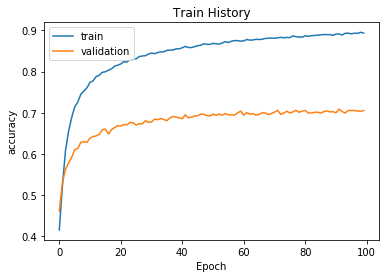

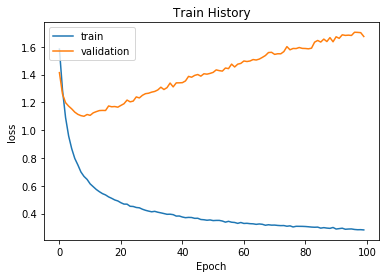

In [7]:
CNN = textCNN(f['concate'], f['tag_Num'])

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN

In [12]:
def rnn(texts, labels):
    training_text, test_text, training_label, test_label = train_test_split(texts, labels, test_size=0.1)

    token = Tokenizer(num_words = 4000)
    token.fit_on_texts(training_text)
    print(token.document_count)

    x_train_seq = token.texts_to_sequences(training_text)
    x_test_seq = token.texts_to_sequences(test_text)
    x_train = sequence.pad_sequences(x_train_seq, maxlen = 400)
    x_test = sequence.pad_sequences(x_test_seq, maxlen = 400)

    y_train = np_utils.to_categorical(training_label)
    y_test = np_utils.to_categorical(test_label)

    model = Sequential()
    model.add(Embedding(output_dim=32,input_dim=4000,input_length=400))
    model.add(Dropout(0.35))
    model.add(SimpleRNN(units=16))
    model.add(Dense(units=256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=128,activation='relu'))
    model.add(Dense(units=8,activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # checkpoint
    # filepath="C:/Users/doudi/OneDrive/Documents/TMU-GIDS/Lab/Competition/AI cup 2019/weights.best.hdf5"
    # checkpoint= ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    train_history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                              epochs=100, batch_size=128, verbose=1, validation_split=0.2)
    scores = model.evaluate(x_test, y_test, verbose=2)
    print(scores[1])
    
    pre_probability = model.predict(x_test)
    predicted = pre_probability.argmax(axis=-1)

    from sklearn import metrics
    print("Classification report for classifier:\n%s\n"
          % ( metrics.classification_report(test_label, predicted)))

    import matplotlib.pyplot as plt
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc = "upper left")
    plt.show()

    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('Train History')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['train','validation'], loc = "upper left")
    plt.show()

42547
Train on 42547 samples, validate on 4728 samples
Epoch 1/100
42547/42547 [==============================] - 70s 2ms/step - loss: 1.5252 - accuracy: 0.4581 - val_loss: 1.4353 - val_accuracy: 0.4865
Epoch 2/100
42547/42547 [==============================] - 69s 2ms/step - loss: 1.3760 - accuracy: 0.5003 - val_loss: 1.3756 - val_accuracy: 0.4932
Epoch 3/100
42547/42547 [==============================] - 69s 2ms/step - loss: 1.2762 - accuracy: 0.5388 - val_loss: 1.3110 - val_accuracy: 0.5110
Epoch 4/100
42547/42547 [==============================] - 69s 2ms/step - loss: 1.1722 - accuracy: 0.5754 - val_loss: 1.2914 - val_accuracy: 0.5273
Epoch 5/100
42547/42547 [==============================] - 69s 2ms/step - loss: 1.0738 - accuracy: 0.6075 - val_loss: 1.2391 - val_accuracy: 0.5423
Epoch 6/100
42547/42547 [==============================] - 69s 2ms/step - loss: 0.9944 - accuracy: 0.6377 - val_loss: 1.2052 - val_accuracy: 0.5516
Epoch 7/100
42547/42547 [==============================] 

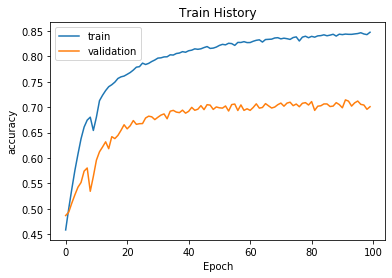

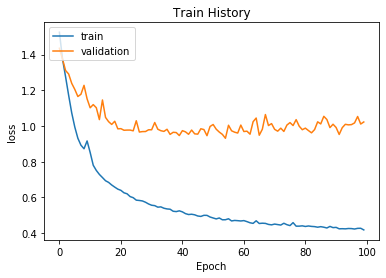

In [14]:
RNN = rnn(f['concate'], f['tag_Num'])